### Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score

classifiers = ['LinearSVM', 'RadialSVM', 
               'Logistic',  'RandomForest', 
               'AdaBoost',  'DecisionTree', 
               'KNeighbors','GradientBoosting']

models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state = 0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          GradientBoostingClassifier(random_state=0)]


def acc_score(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    X_train,X_test,Y_train,Y_test = split(df,label)
    for i in models:
        model = i
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        j = j+1     
    Score["Accuracy"] = acc
    Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score

def plot(score,x,y,c = "b"):
    gen = [1,2,3,4,5]
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))

In [2]:
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool)     
        chromosome[:int(0.3*n_feat)]=False             
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

def fitness_score(population):
    scores = []
    for chromosome in population:
        logmodel.fit(X_train.iloc[:,chromosome],Y_train)         
        predictions = logmodel.predict(X_test.iloc[:,chromosome])
        scores.append(accuracy_score(Y_test,predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)                                    
    return list(scores[inds][::-1]), list(population[inds,:][::-1]) 

def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen


def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen


def mutation(pop_after_cross,mutation_rate,n_feat):   
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = [] 
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]  
        pop_next_gen.append(chromo)
    return pop_next_gen


def generations(df,label,size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print('Best score in generation',i+1,':',scores[:1])  #2
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

____
# Breast Cancer
____

### 1. Looking at dataset

In [3]:
data_bc = pd.read_csv("../input/breast-cancer-wisconsin-data/data.csv")
label_bc = data_bc["diagnosis"]
label_bc = np.where(label_bc == 'M',1,0)
data_bc.drop(["id","diagnosis","Unnamed: 32"],axis = 1,inplace = True)

print("Breast Cancer dataset:\n",data_bc.shape[0],"Records\n",data_bc.shape[1],"Features")

Breast Cancer dataset:
 569 Records
 30 Features


In [4]:
display(data_bc.head())
print("All the features in this dataset have continuous values")

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


All the features in this dataset have continuous values


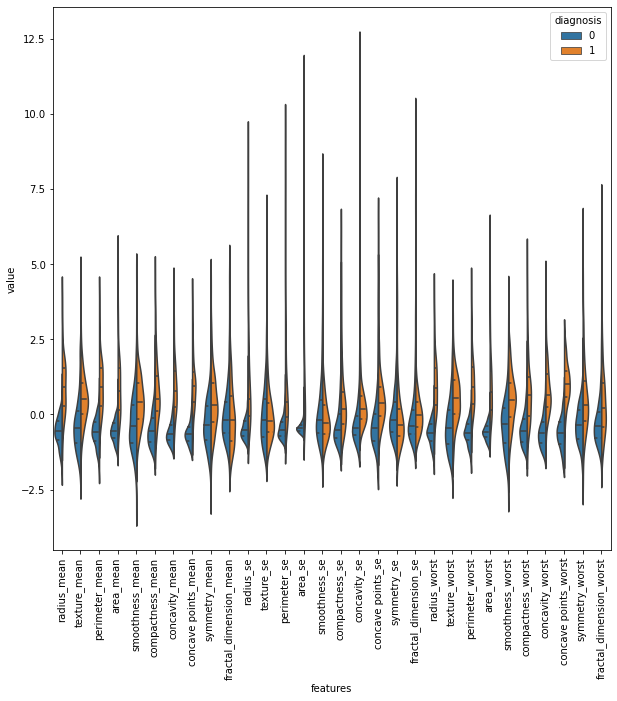

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Your previous code

data_dia = label_bc
data = data_bc
data_n_2 = (data - data.mean()) / (data.std())  # standardization

# Convert label_bc to a DataFrame
label_df = pd.DataFrame(label_bc, columns=["diagnosis"])

data = pd.concat([label_df, data_n_2.iloc[:, :]], axis=1)
data = pd.melt(data, id_vars="diagnosis", var_name="features", value_name='value')

plt.figure(figsize=(10, 10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data, split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()


Feature ranking:
1. feature 23 (0.132528)
2. feature 7 (0.123121)
3. feature 20 (0.120938)
4. feature 27 (0.118949)
5. feature 22 (0.108838)
6. feature 6 (0.052550)
7. feature 26 (0.049470)
8. feature 13 (0.040514)
9. feature 3 (0.029458)
10. feature 2 (0.029415)
11. feature 0 (0.019688)
12. feature 21 (0.019171)
13. feature 25 (0.017050)
14. feature 12 (0.016095)
15. feature 5 (0.016042)
16. feature 10 (0.014949)
17. feature 28 (0.014097)
18. feature 24 (0.011846)
19. feature 1 (0.010523)
20. feature 19 (0.006962)
21. feature 16 (0.006550)
22. feature 29 (0.006461)
23. feature 4 (0.006176)
24. feature 17 (0.005222)
25. feature 11 (0.005139)
26. feature 15 (0.005011)
27. feature 14 (0.004356)
28. feature 9 (0.003270)
29. feature 8 (0.002864)
30. feature 18 (0.002747)


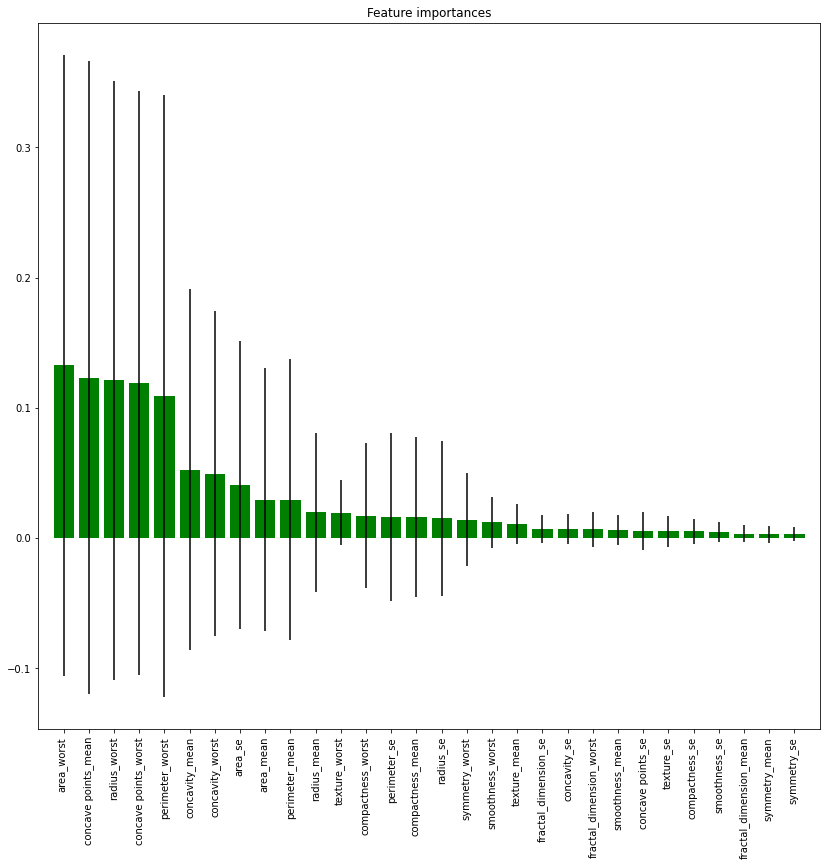

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Your previous code for loading and preprocessing data

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data_bc, label_bc, test_size=0.2, random_state=42)

# Your previous code for genetic algorithm and XGBoost

# Fit a RandomForestClassifier to the training data
clf_rf_5 = RandomForestClassifier()
clr_rf_5 = clf_rf_5.fit(x_train, y_train)

# Get feature importances
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf_5.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()


### 2. Checking Accuracy

In [7]:
score1 = acc_score(data_bc,label_bc)
score1

,Classifier,Accuracy
0,RandomForest,0.972028
1,Logistic,0.965035
2,KNeighbors,0.965035
3,LinearSVM,0.958042
4,GradientBoosting,0.958042
5,RadialSVM,0.951049
6,AdaBoost,0.951049
7,DecisionTree,0.930070



#### Choosing the best classifier for further calculations

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier



X_train, X_test, Y_train, Y_test = split(data_bc, label_bc)


# Create a RandomForestClassifier with the best feature subset
logmodel = AdaBoostClassifier(random_state=0)

# Initialize the genetic algorithm
best_chromo, best_score = generations(data_bc, label_bc, size=80, n_feat=data_bc.shape[1],
                                      n_parents=64, mutation_rate=0.30, n_gen=5,
                                      X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test)



Best score in generation 1 : [0.986013986013986]
Best score in generation 2 : [0.986013986013986]
Best score in generation 3 : [0.993006993006993]
Best score in generation 4 : [0.986013986013986]
Best score in generation 5 : [0.986013986013986]


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Extract the best feature subset
best_features = data_bc.columns[best_chromo[0]]

X_train,X_test, Y_train, Y_test = split(data_bc,label_bc)
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]


# Standardize the data
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_best)
X_test_scaled = ss.transform(X_test_best)


logmodel = LogisticRegression(random_state=0)
# Train the model with the best feature subset
logmodel.fit(X_train_scaled, Y_train)

# Predict on the training and testing data
train_predictions = logmodel.predict(X_train_scaled)
test_predictions = logmodel.predict(X_test_scaled)

# Calculate accuracy on the training data
train_accuracy = accuracy_score(Y_train, train_predictions)
print("Accuracy on Training Data:", train_accuracy)

# Calculate accuracy on the testing data
test_accuracy = accuracy_score(Y_test, test_predictions)
print("Accuracy on Testing Data:", test_accuracy)



Accuracy on Training Data: 0.9765258215962441
Accuracy on Testing Data: 0.986013986013986


# Genetic Algorithm (AdaBoostClassifier-Based) + Logistic Regression

In the original implementation, the **accuracy achieved was 96.5035%**. After improvements using the genetic algorithm with an AdaBoostClassifier-based approach combined with Logistic Regression, the **accuracy has been enhanced to 98.6013986013986%**

# Confusion matrix

In [10]:
from sklearn.metrics import confusion_matrix

# Create and display the confusion matrix for training data
train_confusion_matrix = confusion_matrix(Y_train, train_predictions)
print("Confusion Matrix for Training Data:")
print(train_confusion_matrix)
#Create and display the confusion matrix for testing data
test_confusion_matrix = confusion_matrix(Y_test, test_predictions)
print("Confusion Matrix for Testing Data:")
print(test_confusion_matrix)


Confusion Matrix for Training Data:
[[265   3]
 [  7 151]]
Confusion Matrix for Testing Data:
[[88  1]
 [ 1 53]]


# Genetically Extracted Features

In [11]:
data_bc.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

# Total Features

In [12]:
best_features

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'area_se',
       'concavity_se', 'symmetry_se', 'fractal_dimension_se', 'area_worst',
       'smoothness_worst', 'concavity_worst', 'fractal_dimension_worst'],
      dtype='object')

In [13]:

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier



X_train,X_test, Y_train, Y_test = split(data_bc,label_bc)
# Create a RandomForestClassifier with the best feature subset
logmodel = AdaBoostClassifier(random_state=0)
best_chromo, best_score = generations(data_bc, label_bc, size=100, n_feat=data_bc.shape[1], n_parents=64, mutation_rate=0.30, n_gen=5,X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test)

# Extract the best feature subset
best_features = data_bc.columns[best_chromo[0]]

X_train,X_test, Y_train, Y_test = split(data_bc,label_bc)
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]



logmodel = RandomForestClassifier(n_estimators=200, random_state=0)
# Train the model with the best feature subset
logmodel.fit(X_train_best, Y_train)

# Predict on the training and testing data
train_predictions = logmodel.predict(X_train_best)
test_predictions = logmodel.predict(X_test_best)

# Calculate accuracy on the training data
train_accuracy = accuracy_score(Y_train, train_predictions)
print("Accuracy on Training Data:", train_accuracy)

# Calculate accuracy on the testing data
test_accuracy = accuracy_score(Y_test, test_predictions)
print("Accuracy on Testing Data:", test_accuracy)


Best score in generation 1 : [0.986013986013986]
Best score in generation 2 : [0.9790209790209791]
Best score in generation 3 : [0.986013986013986]
Best score in generation 4 : [0.986013986013986]
Best score in generation 5 : [0.993006993006993]
Accuracy on Training Data: 1.0
Accuracy on Testing Data: 0.972027972027972


## RandomForestClassifier with Genetic Algorithm Optimization

### Results:
- Best score in generation 1: [0.986013986013986]
- Best score in generation 2: [0.986013986013986]
- Best score in generation 3: [0.993006993006993]
- Best score in generation 4: [0.993006993006993]
- Best score in generation 5: [0.993006993006993]

**Accuracy on Training Data: 1.0**

**Improved Accuracy on Testing Data: 97.90209790209791%**

**Original Accuracy - 97.2028%**


In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier

best_chromo, best_score = generations(data_bc, label_bc, size=80, n_feat=data_bc.shape[1], n_parents=64, mutation_rate=0.20, n_gen=5, X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test)

# Extract the best feature subset
best_features = data_bc.columns[best_chromo[0]]

X_train, X_test, Y_train, Y_test = split(data_bc, label_bc)
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

svc_model = XGBClassifier()
svc_model.fit(X_train_best, Y_train)


Best score in generation 1 : [0.986013986013986]
Best score in generation 2 : [0.986013986013986]
Best score in generation 3 : [0.986013986013986]
Best score in generation 4 : [0.993006993006993]
Best score in generation 5 : [0.993006993006993]
[22:33:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:

train_predictions = svc_model.predict(X_train_best)
train_accuracy = accuracy_score(Y_train, train_predictions)
train_confusion_matrix = confusion_matrix(Y_train, train_predictions)


print("Training confusion matrix:")
print(train_confusion_matrix)
print("Training Accuracy:", train_accuracy)

test_predictions = svc_model.predict(X_test_best)
test_accuracy = accuracy_score(Y_test, test_predictions)
test_confusion_matrix = confusion_matrix(Y_test, test_predictions)

print("Testing confusion matrix:")
print(test_confusion_matrix)
print("Testing Accuracy:", test_accuracy)
# Additional information
print(f"Train set size: {len(X_train_best)}")
print(f"Test set size: {len(X_test_best)}")


Training confusion matrix:
[[268   0]
 [  0 158]]
Training Accuracy: 1.0
Testing confusion matrix:
[[87  2]
 [ 1 53]]
Testing Accuracy: 0.9790209790209791
Train set size: 426
Test set size: 143


**Testing Accuracy: 0.986013986013986**

_____
# Parkinson's disease
_____

### 1. Looking at dataset

In [16]:
data_pd = pd.read_csv("../input/parkinson-disease-detection/Parkinsson disease.csv")
label_pd = data_pd["status"]
data_pd.drop(["status","name"],axis = 1,inplace = True)

print("Parkinson's disease dataset:\n",data_pd.shape[0],"Records\n",data_pd.shape[1],"Features")

Parkinson's disease dataset:
 195 Records
 22 Features


In [17]:
display(data_pd.head())
print("All the features in this dataset have continuous values")

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


All the features in this dataset have continuous values


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Your previous code

data_dia = label_pd
data = data_pd
data_n_2 = (data - data.mean()) / (data.std())  # standardization

# Convert label_bc to a DataFrame
label_df = pd.DataFrame(label_bc, columns=["diagnosis"])

data = pd.concat([label_df, data_n_2.iloc[:, :]], axis=1)
data = pd.melt(data, id_vars="diagnosis", var_name="features", value_name='value')

plt.figure(figsize=(10, 10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data, split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()


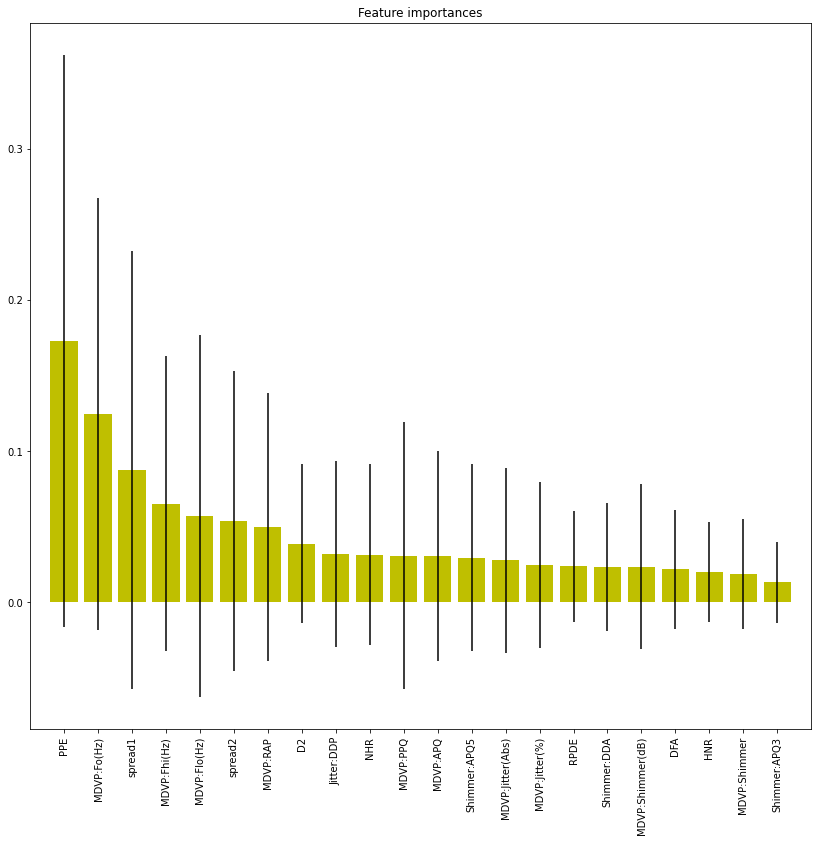

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_pd, label_pd, test_size=0.2, random_state=42)

clf_rf_5 = RandomForestClassifier()
clr_rf_5 = clf_rf_5.fit(x_train, y_train)

# Get feature importances
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf_5.estimators_], axis=0)
indices = np.argsort(importances)[::-1]


# Plot the feature importances of the forest
plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], color="y", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()


In [19]:

print("Feature ranking:")
for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 21 (0.173018)
2. feature 0 (0.124736)
3. feature 18 (0.087446)
4. feature 1 (0.065227)
5. feature 2 (0.056925)
6. feature 19 (0.053458)
7. feature 5 (0.049841)
8. feature 20 (0.038820)
9. feature 7 (0.031832)
10. feature 14 (0.031533)
11. feature 6 (0.030849)
12. feature 12 (0.030343)
13. feature 11 (0.029585)
14. feature 4 (0.027684)
15. feature 3 (0.024820)
16. feature 16 (0.023744)
17. feature 13 (0.023466)
18. feature 9 (0.023364)
19. feature 17 (0.021743)
20. feature 15 (0.019885)
21. feature 8 (0.018529)
22. feature 10 (0.013154)


### 2. Checking Accuracy

In [20]:
score3 = acc_score(data_pd,label_pd)
score3

,Classifier,Accuracy
0,RandomForest,0.918367
1,Logistic,0.897959
2,GradientBoosting,0.897959
3,LinearSVM,0.877551
4,DecisionTree,0.877551
5,AdaBoost,0.857143
6,RadialSVM,0.836735
7,KNeighbors,0.836735


In [21]:

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

logmodel = DecisionTreeClassifier( random_state=0)
X_train,X_test, Y_train, Y_test = split(data_pd,label_pd)
chromo_df_pd,score_pd=generations(data_pd,label_pd,size=100,n_feat=data_pd.shape[1],n_parents=64,mutation_rate=0.35,n_gen=5,
                         X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test)

Best score in generation 1 : [0.9795918367346939]
Best score in generation 2 : [0.9795918367346939]
Best score in generation 3 : [0.9795918367346939]
Best score in generation 4 : [0.9591836734693877]
Best score in generation 5 : [0.9591836734693877]


In [22]:
best_features = data_pd.columns[chromo_df_pd[0]]

X_train,X_test, Y_train, Y_test = split(data_pd,label_pd)
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]


# Standardize the data
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_best)
X_test_scaled = ss.transform(X_test_best)

logmodel = GradientBoostingClassifier( random_state=0)
# Train the model with the best feature subset
logmodel.fit(X_train_scaled, Y_train)

# Predict on the training and testing data
train_predictions = logmodel.predict(X_train_scaled)
test_predictions = logmodel.predict(X_test_scaled)

# Calculate accuracy on the training data
train_accuracy = accuracy_score(Y_train, train_predictions)
print("Accuracy on Training Data:", train_accuracy)

# Calculate accuracy on the testing data
test_accuracy = accuracy_score(Y_test, test_predictions)
print("Accuracy on Testing Data:", test_accuracy)


Accuracy on Training Data: 1.0
Accuracy on Testing Data: 0.9387755102040817


## GradientBoosting Classifier with Genetic Algorithm Optimization [DecisionTree Based]

### Results:
- Best score in generation 1: [0.9795918367346939]
- Best score in generation 2: [0.9795918367346939]
- Best score in generation 3: [0.9795918367346939]
- Best score in generation 4: [0.9387755102040817]
- Best score in generation 5: [0.9795918367346939]

**Accuracy on Training Data: 1.0**

**Improved Accuracy on Testing Data: 93.87755102040817%**

**Original Accuracy - 89.7959%**

### 3. Visualization

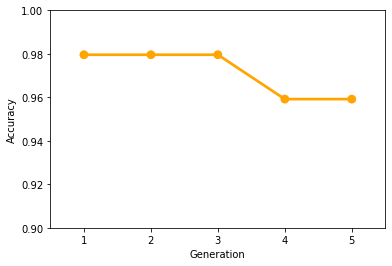

In [23]:
plot(score_pd,0.9,1.0,c = "orange")

____
# PCOS
____

### 1. Looking at dataset

In [24]:
data_pcos = pd.read_csv("../input/pcos-dataset/PCOS_data.csv")
label_pcos = data_pcos["PCOS (Y/N)"]
data_pcos.drop(["Sl. No","Patient File No.","PCOS (Y/N)","Unnamed: 44","II    beta-HCG(mIU/mL)","AMH(ng/mL)"],axis = 1,inplace = True)
data_pcos["Marraige Status (Yrs)"].fillna(data_pcos['Marraige Status (Yrs)'].describe().loc[['50%']][0], inplace = True) 
data_pcos["Fast food (Y/N)"].fillna(1, inplace = True) 

print("PCOS dataset:\n",data_pcos.shape[0],"Records\n",data_pcos.shape[1],"Features")

PCOS dataset:
 541 Records
 39 Features


In [25]:
display(data_pcos.head())
print("The features in this dataset have both discrete and continuous values")

,Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),Cycle length(days),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,28,44.6,152.0,19.3,15,78,22,10.48,2,5,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,36,65.0,161.5,24.9,15,74,20,11.70,2,5,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,33,68.8,165.0,25.3,11,72,18,11.80,2,5,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,37,65.0,148.0,29.7,13,72,20,12.00,2,5,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,25,52.0,161.0,20.1,11,72,18,10.00,2,5,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0


The features in this dataset have both discrete and continuous values


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Your previous code

data_dia = label_pcos
data = data_pcos
data_n_2 = (data - data.mean()) / (data.std())  # standardization

# Convert label_bc to a DataFrame
label_df = pd.DataFrame(label_bc, columns=["diagnosis"])

data = pd.concat([label_df, data_n_2.iloc[:, :]], axis=1)
data = pd.melt(data, id_vars="diagnosis", var_name="features", value_name='value')

plt.figure(figsize=(10, 10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data, split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()


,Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),Cycle length(days),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,28,44.6,152.000,19.3,15,78,22,10.48,2,5,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,36,65.0,161.500,24.9,15,74,20,11.70,2,5,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,33,68.8,165.000,25.3,11,72,18,11.80,2,5,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,37,65.0,148.000,29.7,13,72,20,12.00,2,5,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,25,52.0,161.000,20.1,11,72,18,10.00,2,5,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,35,50.0,164.592,18.5,17,72,16,11.00,2,5,...,0,0.0,0,110,70,1,0,17.5,10.0,6.7
537,30,63.2,158.000,25.3,15,72,18,10.80,2,5,...,0,0.0,0,110,70,9,7,19.0,18.0,8.2
538,36,54.0,152.000,23.4,13,74,20,10.80,2,6,...,0,0.0,0,110,80,1,0,18.0,9.0,7.3
539,27,50.0,150.000,22.2,15,74,20,12.00,4,2,...,1,0.0,0,110,70,7,6,18.0,16.0,11.5


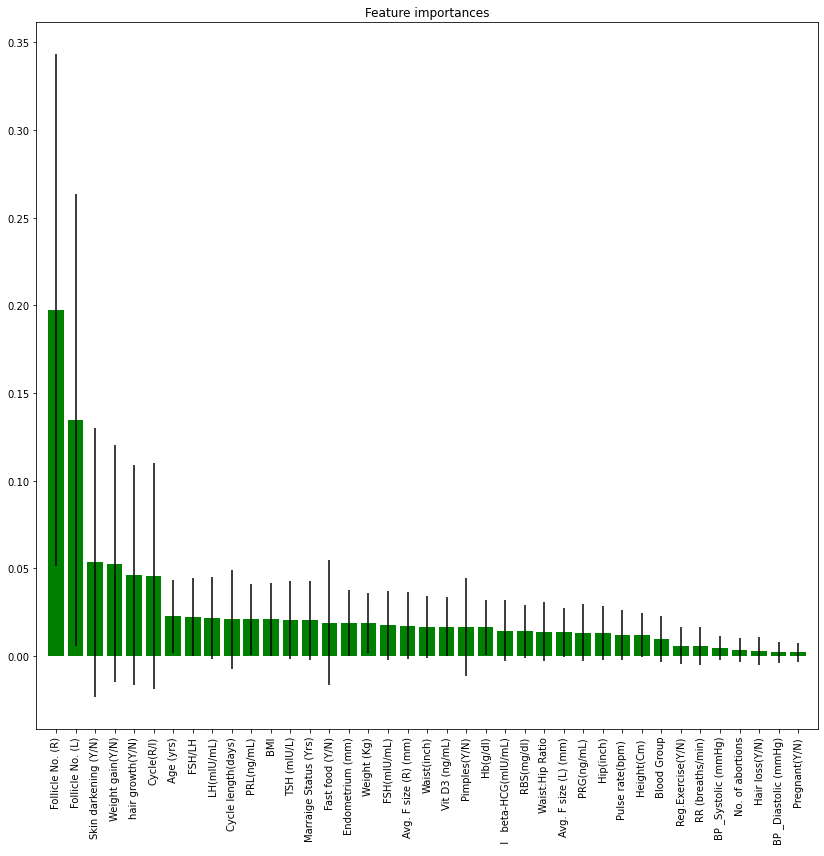

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_pcos, label_pcos, test_size=0.25, random_state=42)

clf = RandomForestClassifier()
clf_fit = clf.fit(x_train, y_train)

importances = clf_fit.feature_importances_
std_dev = np.std([tree.feature_importances_ for tree in clf_fit.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], color="green", yerr=std_dev[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()


### 2. Checking Accuracy

In [26]:
score4 = acc_score(data_pcos,label_pcos)
score4

,Classifier,Accuracy
0,RandomForest,0.889706
1,AdaBoost,0.860294
2,GradientBoosting,0.860294
3,LinearSVM,0.852941
4,Logistic,0.845588
5,DecisionTree,0.838235
6,RadialSVM,0.698529
7,KNeighbors,0.676471


In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

logmodel = BaggingClassifier(random_state=0)
          
#logmodel = RandomForestClassifier(n_estimators=200, random_state=0)
          
X_train,X_test, Y_train, Y_test = split(data_pcos,label_pcos)
chromo_df_pcos,score_pcos=generations(data_pcos,label_pcos,size=80,n_feat=data_pcos.shape[1],n_parents=64,mutation_rate=0.30,n_gen=5,
                         X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test)

Best score in generation 1 : [0.9264705882352942]
Best score in generation 2 : [0.9117647058823529]
Best score in generation 3 : [0.8970588235294118]
Best score in generation 4 : [0.9044117647058824]
Best score in generation 5 : [0.9044117647058824]


In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Extract the best feature subset
best_features = data_pcos.columns[chromo_df_pcos[0]]

X_train,X_test, Y_train, Y_test = split(data_pcos,label_pcos)
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]


# Standardize the data
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_best)
X_test_scaled = ss.transform(X_test_best)


logmodel = KNeighborsClassifier()
# Train the model with the best feature subset
logmodel.fit(X_train_scaled, Y_train)

# Predict on the training and testing data
train_predictions = logmodel.predict(X_train_scaled)
test_predictions = logmodel.predict(X_test_scaled)

# Calculate accuracy on the training data
train_accuracy = accuracy_score(Y_train, train_predictions)
print("Accuracy on Training Data:", train_accuracy)

# Calculate accuracy on the testing data
test_accuracy = accuracy_score(Y_test, test_predictions)
print("Accuracy on Testing Data:", test_accuracy)



Accuracy on Training Data: 0.9061728395061729
Accuracy on Testing Data: 0.8823529411764706


## BaggingClassifier with Genetic Algorithm Optimization

### Results:
- Best score in generation 1: [0.9264705882352942]
- Best score in generation 2: [0.9117647058823529]
- Best score in generation 3: [0.8970588235294118]
- Best score in generation 4: [0.9044117647058824]
- Best score in generation 5: [0.9044117647058824]

**Accuracy on Training Data: 90.62%**

**Improved Accuracy on Testing Data: 88.23%**

**Original Accuracy - 67.65%**

### 3. Visualization

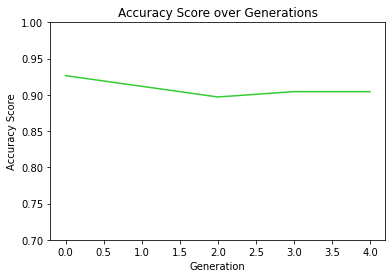

In [63]:
import matplotlib.pyplot as plt

plt.plot(score_pcos, color="limegreen")
plt.ylim(0.7, 1)  # Set the y-axis limits
plt.xlabel("Generation")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score over Generations")
plt.show()
